In [9]:
import osmnx as ox
import folium
from shapely.geometry import mapping, Point
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx

In [10]:
G = ox.graph_from_place("Exeter, England", network_type="walk")

# Convert nodes and edges to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [11]:
crime_edges = gpd.read_file("edges_with_idw_scores.gpkg") 
pedestrian_edges = gpd.read_file("edges_with_pedestrian_weights.gpkg")

In [12]:
def normalize_weights(crime_edges, pedestrian_edges, crime_col='idw_score', ped_col='pedestrian_weight', weight_col='routing_weight', w_c=0.5, w_p=0.5):
    """
    Normalize and combine crime and pedestrian safety scores to create a routing weight.

    Parameters:
    - crime_edges (GeoDataFrame): Crime-weighted edges with `idw_score` column (range: 0 to 3).
    - pedestrian_edges (GeoDataFrame): Pedestrian-weighted edges with `pedestrian_weighting` column (range: 0 to 6).
    - crime_col (str): Column name for crime scores.
    - ped_col (str): Column name for pedestrian scores.
    - weight_col (str): Name of the output column for routing weights.
    - w_c (float): Weight for crime safety score.
    - w_p (float): Weight for pedestrian safety score.

    Returns:
    - GeoDataFrame: Merged and updated edges with normalized routing weight.
    """

    # Merge crime and pedestrian data on common keys
    edges = crime_edges.merge(pedestrian_edges[['u', 'v', 'key', ped_col]], on=['u', 'v', 'key'], how='left')

    # Fill missing pedestrian scores with 0 (assume worst-case)
    edges[ped_col] = edges[ped_col].fillna(0)

    # Normalize crime scores (0 = safest, 3 = most dangerous → invert properly)
    edges['crime_norm'] = (3 - edges[crime_col]) / 3  # Scale from [0,3] → [0,1]

    # Normalize pedestrian scores (0 = unsafe, 6 = safest → keep same direction)
    edges['ped_norm'] = edges[ped_col] / 6  # Scale from [0,6] → [0,1]

    # Compute final safety score (higher = safer) and clip between [0,1]
    edges['safety_score'] = (w_c * edges['crime_norm'] + w_p * edges['ped_norm']).clip(0, 1)

    # Invert for routing (lower weight = safer)
    edges[weight_col] = 1 - edges['safety_score']

    return edges

In [13]:
combined_edges = normalize_weights(crime_edges, pedestrian_edges)

In [14]:
combined_edges = combined_edges.groupby(["u", "v", "key"], as_index=False).agg({
    "osmid": "first",   # Keep first osmid (or convert to list if multiple exist)
    "oneway": "first",
    "reversed": "first",
    "length": "mean",  # Average length (adjust as needed)
    "bridge": "first",
    "junction": "first",
    "access": "first",
    "est_width": "first",
    "landuse": "first",
    "u_score": "mean",
    "v_score": "mean",
    "idw_score": "mean",
    "pedestrian_weight": "mean",
    "crime_norm": "mean",
    "ped_norm": "mean",
    "safety_score": "mean",
    "routing_weight": "min",  # Keep the safest route
    "geometry": "first"  # Keep one geometry
})


In [15]:
combined_edges = combined_edges.set_index(["u", "v", "key"])

In [16]:
# Ensure 'combined_edges' is a GeoDataFrame with the correct CRS
combined_edges = gpd.GeoDataFrame(combined_edges, geometry="geometry", crs="EPSG:4326")

In [17]:
G = ox.graph_from_gdfs(nodes, combined_edges)

In [18]:
def find_safest_route(G, start_node, end_node):
    try:
        return nx.shortest_path(G, source=start_node, target=end_node, weight="routing_weight")
    except nx.NetworkXNoPath:
        return None

def find_shortest_route(G, start_node, end_node):
    try:
        return nx.shortest_path(G, source=start_node, target=end_node, weight="length")
    except nx.NetworkXNoPath:
        return None


In [19]:
def extract_route_metrics(route, G, route_type):
    total_weight = 0
    total_length = 0

    for u, v in zip(route[:-1], route[1:]):
        edge_data = G.get_edge_data(u, v)
        if G.is_multigraph():
            edge_data = list(edge_data.values())[0]  # use first edge
        total_weight += edge_data.get("routing_weight", 0)
        total_length += edge_data.get("length", 0)

    safety_score = round((total_weight / total_length) * 1000, 2) if total_length > 0 else float("inf")
    
    return {
        "start_node": route[0],
        "end_node": route[-1],
        "route_type": route_type,
        "total_length": round(total_length, 2),
        "total_weight": round(total_weight, 2),
        "safety_score": safety_score
    }


In [82]:
# Test point
start_point = (50.74504, -3.54129)  
end_point = (50.74270, -3.52567)

In [84]:
# Find the nearest nodes to the start and end points
start_node = ox.distance.nearest_nodes(G, X=start_point[1], Y=start_point[0])
end_node = ox.distance.nearest_nodes(G, X=end_point[1], Y=end_point[0])

In [404]:
shortest_route = find_shortest_route(G, start_node, end_node)
safest_route = find_safest_route(G, start_node, end_node)


In [406]:
shortest = extract_route_metrics(shortest_route, G, "shortest")
safest = extract_route_metrics(safest_route, G, "safest")

In [410]:
route = folium.Map(location=start_point, zoom_start=15, tiles="CartoDB Positron")

# Plot both routes on the map
# 1. Shortest route (blue)
shortest_coords = [(G.nodes[node]["y"], G.nodes[node]["x"]) for node in shortest_route]
folium.PolyLine(shortest_coords, color="blue", weight=5, opacity=0.7, popup="Shortest Route").add_to(route)

# 2. Safest route (green)
safest_coords = [(G.nodes[node]["y"], G.nodes[node]["x"]) for node in safest_route]
folium.PolyLine(safest_coords, color="green", weight=5, opacity=0.7, popup="Safest Route").add_to(route)

# Add start and end markers
folium.Marker(start_point, popup="Start Point", icon=folium.Icon(color="red")).add_to(route)
folium.Marker(end_point, popup="End Point", icon=folium.Icon(color="red")).add_to(route)

route

In [110]:
route.save("merged_route4.html")

In [21]:
import random

def generate_random_node_pairs(G, n=100, min_dist=500, max_dist=2000):
    nodes = list(G.nodes)
    pairs = []
    
    while len(pairs) < n:
        start, end = random.sample(nodes, 2)
        try:
            # Check path length using real edge distances (in meters)
            safest_route = find_safest_route(G, start, end)
            safest = extract_route_metrics(safest_route, G, "safest")
            length = safest["total_length"]
            if min_dist <= length <= max_dist:
                pairs.append((start, end))
        except nx.NetworkXNoPath:
            continue  # Skip if no valid path

    return pairs


In [25]:
routes_data = []

pairs = generate_random_node_pairs(G, n=200)

for route_id, (start, end) in enumerate(pairs):
    shortest = find_shortest_route(G, start, end)
    safest = find_safest_route(G, start, end)

    if shortest and safest:
        # Add route_id to each route's metrics
        shortest_metrics = extract_route_metrics(shortest, G, "shortest")
        shortest_metrics["route_id"] = route_id
        routes_data.append(shortest_metrics)

        safest_metrics = extract_route_metrics(safest, G, "safest")
        safest_metrics["route_id"] = route_id
        routes_data.append(safest_metrics)

In [44]:
# Load back saved routes
with open("routes_data.json", "r") as f:
    routes_data = json.load(f)

In [46]:
df_routes = pd.DataFrame(routes_data)

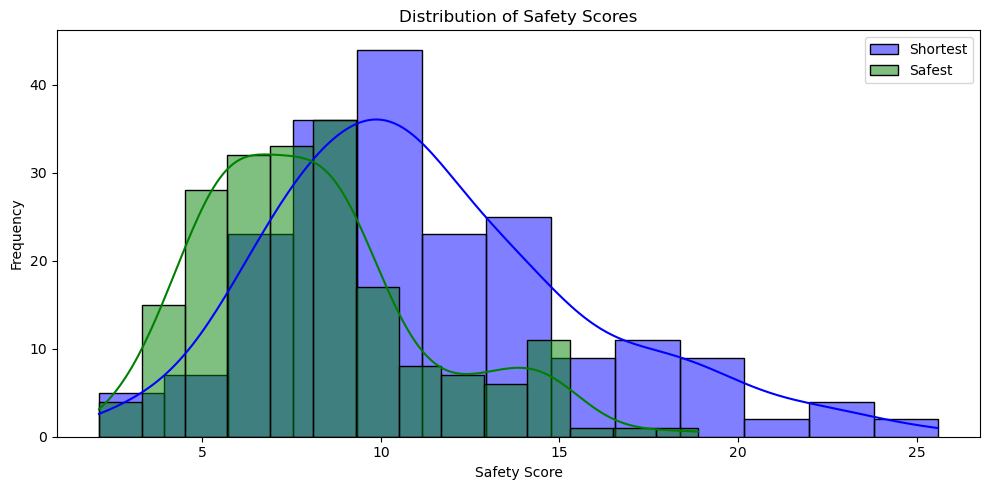

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram comparison
plt.figure(figsize=(10, 5))
sns.histplot(data=df_routes[df_routes["route_type"] == "shortest"], x="safety_score", color="blue", label="Shortest", kde=True)
sns.histplot(data=df_routes[df_routes["route_type"] == "safest"], x="safety_score", color="green", label="Safest", kde=True)
plt.title("Distribution of Safety Scores")
plt.xlabel("Safety Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
#plt.savefig("safety_score_distribution.png", dpi=300)
plt.show()


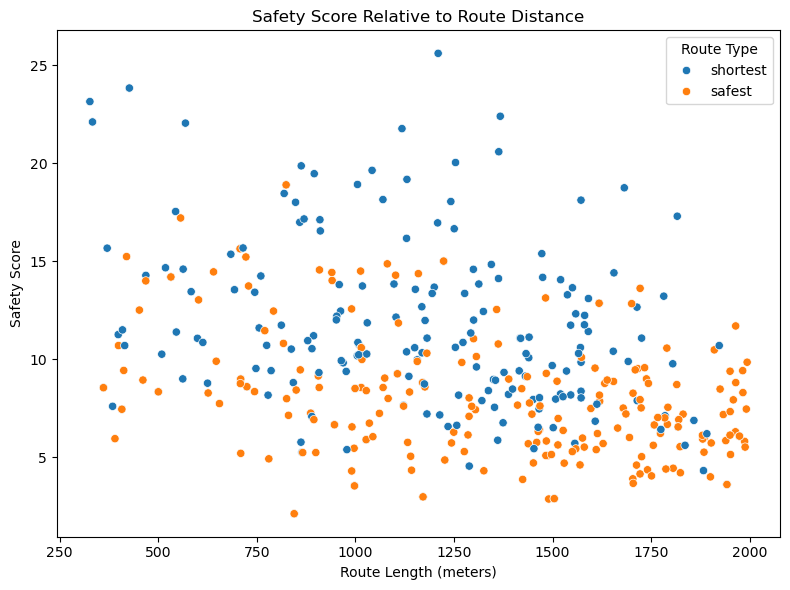

In [49]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_routes, x="total_length", y="safety_score", hue="route_type")
plt.title("Safety Score Relative to Route Distance")
plt.xlabel("Route Length (meters)")
plt.ylabel("Safety Score")
plt.legend(title="Route Type")
plt.tight_layout()
#plt.savefig("length_vs_safety.png", dpi=300)
plt.show()


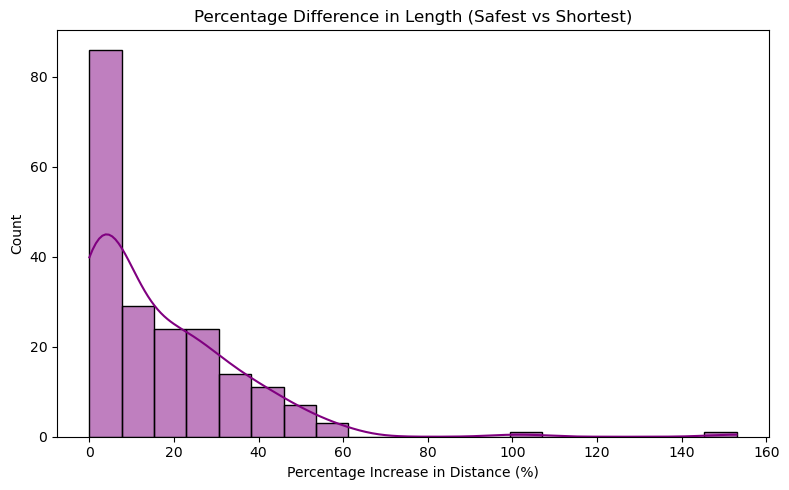

In [51]:
# Pivot table to compare shortest and safest
pivot = df_routes.pivot_table(index=["start_node", "end_node"], columns="route_type", values="total_length").reset_index()
pivot["length_diff_pct"] = ((pivot["safest"] - pivot["shortest"]) / pivot["shortest"]) * 100

# Histogram of percent difference
plt.figure(figsize=(8, 5))
sns.histplot(pivot["length_diff_pct"], kde=True, color="purple")
plt.title("Percentage Difference in Length (Safest vs Shortest)")
plt.xlabel("Percentage Increase in Distance (%)")
plt.ylabel("Count")
plt.tight_layout()
#plt.savefig("percentage_length_difference.png", dpi=300)
plt.show()


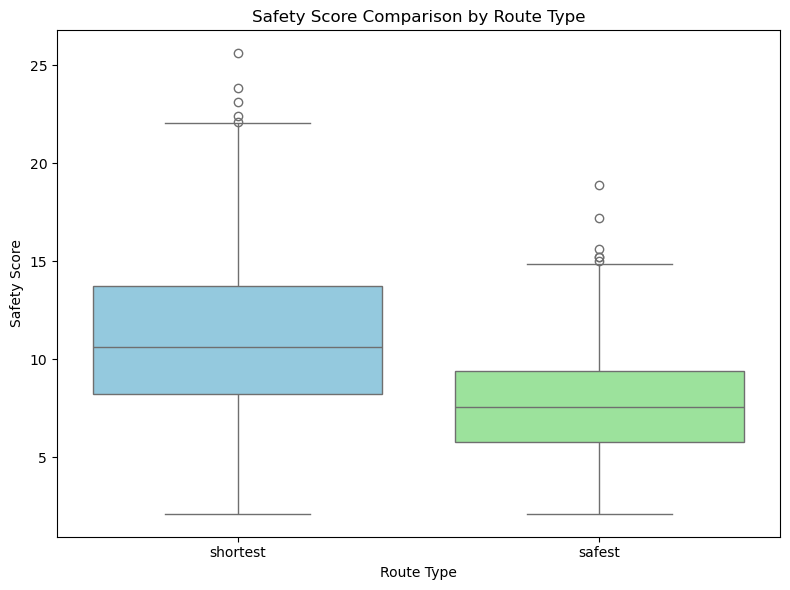

In [52]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_routes, x="route_type", y="safety_score", hue="route_type", palette=["skyblue", "lightgreen"], legend=False)
plt.title("Safety Score Comparison by Route Type")
plt.xlabel("Route Type")
plt.ylabel("Safety Score")
plt.tight_layout()
#plt.savefig("score_comparison_by_route.png", dpi=300)
plt.show()


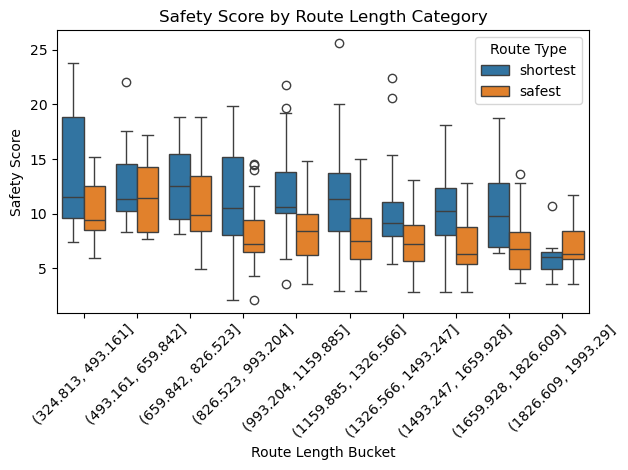

In [53]:
df_routes["length_bucket"] = pd.cut(df_routes["total_length"], bins=10)

sns.boxplot(x="length_bucket", y="safety_score", hue="route_type", data=df_routes)
plt.xticks(rotation=45)
plt.xlabel("Route Length Bucket")
plt.ylabel("Safety Score")
plt.title("Safety Score by Route Length Category")
plt.legend(title="Route Type")
plt.tight_layout()
#plt.savefig("safety_score_length_buckets.png", dpi=300)
plt.show()

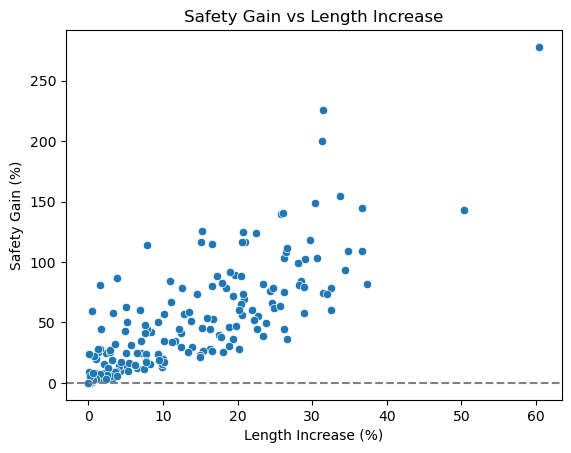

In [54]:
# Pivot to make comparison easier
pivot = df_routes.pivot(index="route_id", columns="route_type", values=["safety_score", "total_length"])
pivot.columns = ["safety_shortest", "safety_safest", "length_shortest", "length_safest"]

# Calculate % difference
pivot["safety_gain_%"] = (
    (pivot["safety_shortest"] - pivot["safety_safest"]) / pivot["safety_shortest"]
) * 100

pivot["length_increase_%"] = (
    (pivot["length_safest"] - pivot["length_shortest"]) / pivot["length_shortest"]
) * 100

# Flip safety gain so that a higher value = safer
pivot["safety_gain_%"] = -pivot["safety_gain_%"]

# Take absolute value to show positive % increase in length
pivot["length_increase_%"] = pivot["length_increase_%"].abs()

# Plot
sns.scatterplot(
    data=pivot,
    x="length_increase_%",
    y="safety_gain_%"
)

plt.axhline(0, color='gray', linestyle='--')
plt.title("Safety Gain vs Length Increase")
plt.xlabel("Length Increase (%)")
plt.ylabel("Safety Gain (%)")
#plt.savefig("dafety_vs_length_trade-off.png", dpi=300)
plt.show()



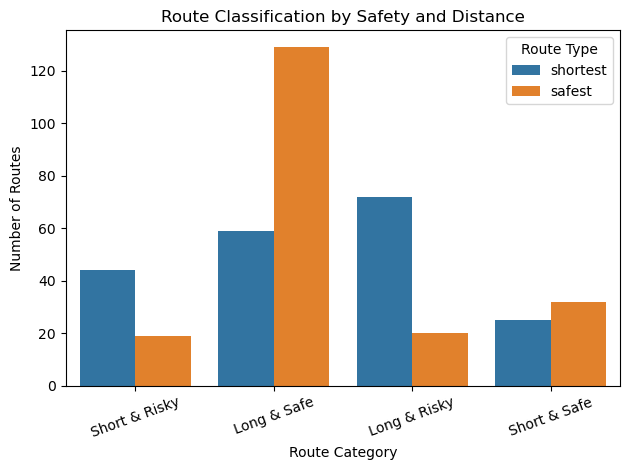

In [56]:
def classify(row):
    if row["safety_score"] < 10 and row["total_length"] < 1000:
        return "Short & Safe"
    elif row["safety_score"] < 10:
        return "Long & Safe"
    elif row["total_length"] < 1000:
        return "Short & Risky"
    else:
        return "Long & Risky"

df_routes["classification"] = df_routes.apply(classify, axis=1)

sns.countplot(data=df_routes, x="classification", hue="route_type")
plt.title("Route Classification by Safety and Distance")
plt.xlabel("Route Category")
plt.ylabel("Number of Routes")
plt.xticks(rotation=20)
plt.legend(title="Route Type")
plt.tight_layout()
#plt.savefig("route_classification_comparison.png", dpi=300)
plt.show()


In [61]:
pivot = df_routes.pivot(index="route_id", columns="route_type", values="safety_score")

pivot["safety_score_diff"] = pivot["shortest"] - pivot["safest"]

top_drops = pivot.sort_values("safety_score_diff", ascending=False)

# Show top N route_ids with biggest safety improvements
print(top_drops.head(5))


route_type  safest  shortest  safety_score_diff
route_id                                       
111          10.47     25.60              15.13
131           7.45     22.39              14.94
39            9.51     20.58              11.07
118           3.86     14.59              10.73
44            9.45     20.03              10.58


In [63]:
# Filter for the route_id
route_info = df_routes[df_routes["route_id"] == 39]

# Extract start and end node 
start_node = int(route_info.iloc[0]["start_node"])
end_node = int(route_info.iloc[0]["end_node"])

print("Start Node:", start_node)
print("End Node:", end_node)


Start Node: 84907847
End Node: 34917773


In [64]:
route_info

,start_node,end_node,route_type,total_length,total_weight,safety_score,route_id,length_bucket,classification
78,84907847,34917773,shortest,1363.45,28.06,20.58,39,"(1326.566, 1493.247]",Long & Risky
79,84907847,34917773,safest,1716.03,16.32,9.51,39,"(1659.928, 1826.609]",Long & Safe


In [522]:
shortest_route = find_shortest_route(G, start_node, end_node)
safest_route = find_safest_route(G, start_node, end_node)

In [526]:
routes = folium.Map(location=(slat, slon), zoom_start=15, tiles="CartoDB Positron")

slat = G.nodes[shortest_route[0]]["y"]
slon = G.nodes[shortest_route[0]]["x"]

flat = G.nodes[shortest_route[-1]]["y"]
flon = G.nodes[shortest_route[-1]]["x"]

# Plot shortest route
shortest_coords = [(G.nodes[node]["y"], G.nodes[node]["x"]) for node in shortest_route]
folium.PolyLine(shortest_coords, color="blue", weight=5, opacity=0.7, popup="Shortest Route").add_to(routes)

# Plot safest route
safest_coords = [(G.nodes[node]["y"], G.nodes[node]["x"]) for node in safest_route]
folium.PolyLine(safest_coords, color="green", weight=5, opacity=0.7, popup="Safest Route").add_to(routes)

# Start and end markers
folium.Marker(location=(slat, slon), popup="Start", icon=folium.Icon(color="red")).add_to(routes)
folium.Marker(location=(flat, flon), popup="End", icon=folium.Icon(color="red")).add_to(routes)

#routes.save("report_route1.html")
routes